# Import

In [9]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Data

In [12]:
data = pd.read_parquet('proc_data')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8636 entries, C10001 to C19190
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8636 non-null   float64
 1   BALANCE_FREQUENCY                 8636 non-null   float64
 2   PURCHASES                         8636 non-null   float64
 3   ONEOFF_PURCHASES                  8636 non-null   float64
 4   INSTALLMENTS_PURCHASES            8636 non-null   float64
 5   CASH_ADVANCE                      8636 non-null   float64
 6   PURCHASES_FREQUENCY               8636 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8636 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8636 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8636 non-null   float64
 10  CASH_ADVANCE_TRX                  8636 non-null   int64  
 11  PURCHASES_TRX                     8636 non-null   int64  
 12  CRED

In [13]:
tsne_columns = [f"tsne{i+1}" for i in range(3)]
pca_columns = [f"pca{i+1}" for i in range(3)]
pca_tsne_cols = tsne_columns + pca_columns
num_features = [x for x in data.columns if x not in pca_tsne_cols]
print(f'{len(pca_tsne_cols)=}')
print(f'{len(num_features)=}')

len(pca_tsne_cols)=6
len(num_features)=17


In [15]:
features = data.drop(pca_tsne_cols, axis=1)
features.shape

(8636, 17)

# Pipeline

In [20]:
def get_kmeans_pipeline():
    _std = ColumnTransformer(
        transformers=[
            ('num_features', StandardScaler(), num_features),
        ]
    )
    _normalize = Normalizer(norm='l2')
    _pca = PCA(n_components=3)
    _kmeans = KMeans(n_clusters=3)
    pipeline = Pipeline(
        steps=[
            ('std', _std),
            ('normalize', _normalize),
            ('pca', _pca),
            ('kmeans', _kmeans),
        ]
    )
    return pipeline
kmeans_pipeline = get_kmeans_pipeline()

# Calc silhouette

In [23]:
%%time
def calc_silhouette(X, pipeline):
    silhouette_avg = list()
    for cluster_num in tqdm(range(2, 10)):
        # kmeans = KMeans(
        #     n_clusters=cluster_num,
        #     init='k-means++',
        #     random_state=42,
        # )
        # kmeans.fit(X)
        pipeline.fit(X)
        kmeans = pipeline.named_steps['kmeans']
        labels = kmeans.labels_
        silhouette_avg.append(silhouette_score(X, labels))
    return silhouette_avg
silhouette_avg = calc_silhouette(features, kmeans_pipeline)

100%|███████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.41it/s]

CPU times: user 13.3 s, sys: 15.2 s, total: 28.5 s
Wall time: 5.69 s


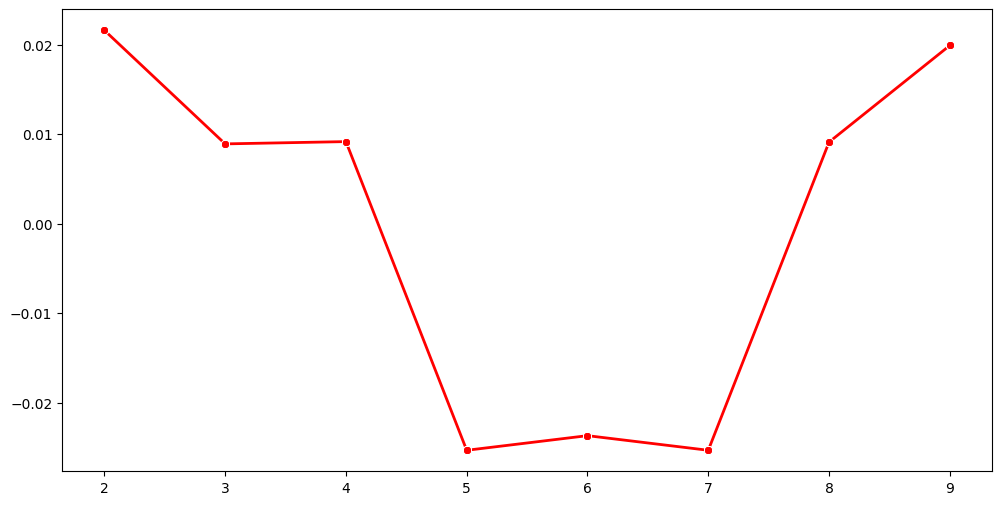

In [24]:
plt.figure(figsize=(12,6))
sns.lineplot(x=range(2,10),y=silhouette_avg,linewidth=2,color='red',marker='8')
plt.show()

# KMeans

In [27]:
kmeans_pipeline.set_params(kmeans__n_clusters=4)
cluster = kmeans_pipeline.fit_predict(features)
features['cluster'] = cluster
features['cluster'].value_counts()

cluster
0    3255
3    2151
2    1723
1    1507
Name: count, dtype: int64

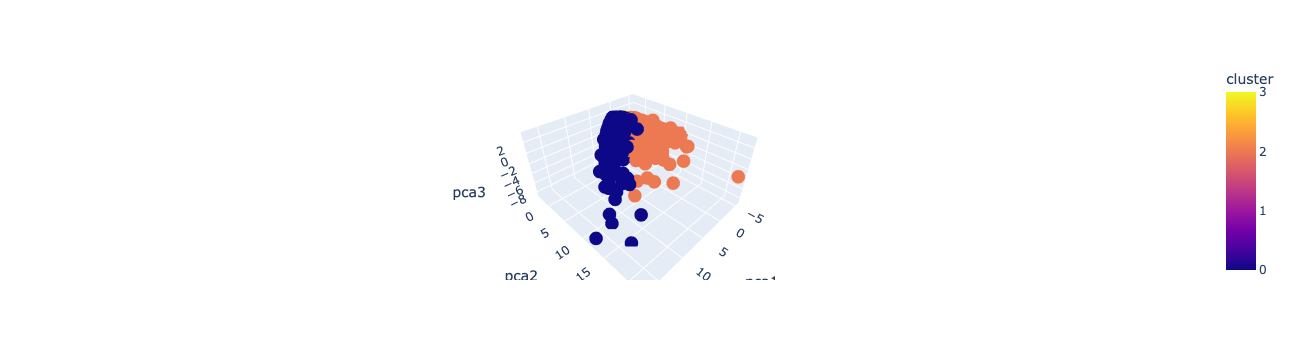

In [38]:
_std = kmeans_pipeline.named_steps['std'].transform(features)
_noramlize = kmeans_pipeline.named_steps['normalize'].transform(_std)
_pca = kmeans_pipeline.named_steps['pca'].transform(_std)
pca_result = pd.DataFrame(data=_pca)
pca_result.columns = ['pca1', 'pca2', 'pca3']
pca_result['cluster'] = features.cluster.values
px.scatter_3d(
    pca_result,
    x='pca1',
    y='pca2',
    z='pca3',
    color='cluster',
    # opacity=0.7,
)